In [10]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

# Load the full scan

In [4]:
fc = FileChooser('/sf/alvra/data/p17589/res/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p17589/res/scan_info', filename='', show_hidden='False')

In [11]:
quantile_band = 0.5

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122L]
channel_list_all = channel_list_pp + [channel_waveplate]

#######################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Waveplate_deg  = scan.readbacks

DataFluo_pump = []
DataFluo_unpump = []
Pump_probe = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    
    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
    
    IzeroFEL_pump_shot = resultsPP[channel_Izero122L].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero122L].unpump
    DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
    
    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
    
    df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
    df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
    df_pump_probe = pd.DataFrame(Pump_probe_shot)

    DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    print ("correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))

DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

print ("Job done!")




--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet             1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET            1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-CVME-PBPS1:Lnk9Ch7-DATA-SUM 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV6_NBS   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Step 11 of 11: Processing FeBpy_fluence_scan_7123eV_5ps_001_step0010
correlation = 0.9948905484600169
Job done!


# Plot Fluence scan

<IPython.core.display.Javascript object>


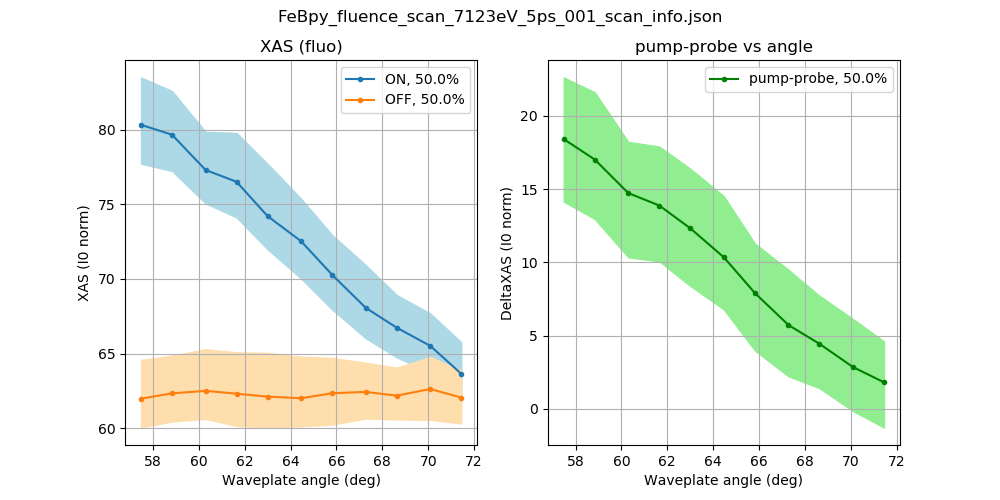

In [16]:
plt.figure(figsize = (10,5))
plt.suptitle(fc.selected.split('/')[-1], fontsize=12)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_pump = DataFluo_pump[:,0]
err_low_pump = DataFluo_pump[:,1]
err_high_pump = DataFluo_pump[:,2]
XAS_unpump = DataFluo_unpump[:,0]
err_low_unpump = DataFluo_unpump[:,1]
err_high_unpump = DataFluo_unpump[:,2]
XAS_pump_probe = Pump_probe[:,0]
err_low_pump_probe = Pump_probe[:,1]
err_high_pump_probe = Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Waveplate_deg, XAS_pump, label='ON, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Waveplate_deg, err_low_pump, err_high_pump, color='lightblue')

plt.plot(Waveplate_deg, XAS_unpump, label='OFF, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Waveplate_deg, err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Waveplate angle (deg)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Waveplate_deg, XAS_pump_probe, label='pump-probe, {}%'.format(quantile_band*100),color='green', marker='.')
plt.fill_between(Waveplate_deg,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Waveplate angle (deg)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs angle')
plt.legend(loc="best")
plt.grid()

plt.show()



# Calculate laser fluence 

In [17]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

[71.4375 70.0875 68.625  67.275  65.8125 64.4625 63.     61.65   60.3
 58.8375 57.4875]
[294.57418891 300.29098644 306.16636561 311.28353047 316.48180893
 320.95006004 325.42117553 329.19748117 332.62831071 335.9463667
 338.63389868]


<IPython.core.display.Javascript object>


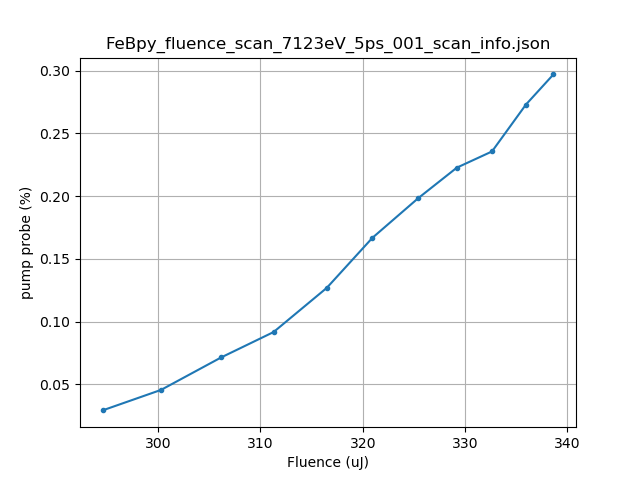

In [20]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(fc.selected.split('/')[-1])
plt.plot(fluences, XAS_pump_probe/XAS_unpump, marker = '.')
plt.grid()
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')
plt.show()

# Load one step and check I0 filtering

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:37 07.07.2019
    mtime difference: -0:11:19.007286
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF06T04V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF06T04V01.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:45 07.07.2019
    mtime difference: -0:19:33.451366
SFDataFiles("/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.BSREAD.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF02T09V02.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF06T04V01.h5"): 62 channels

----------

<IPython.core.display.Javascript object>


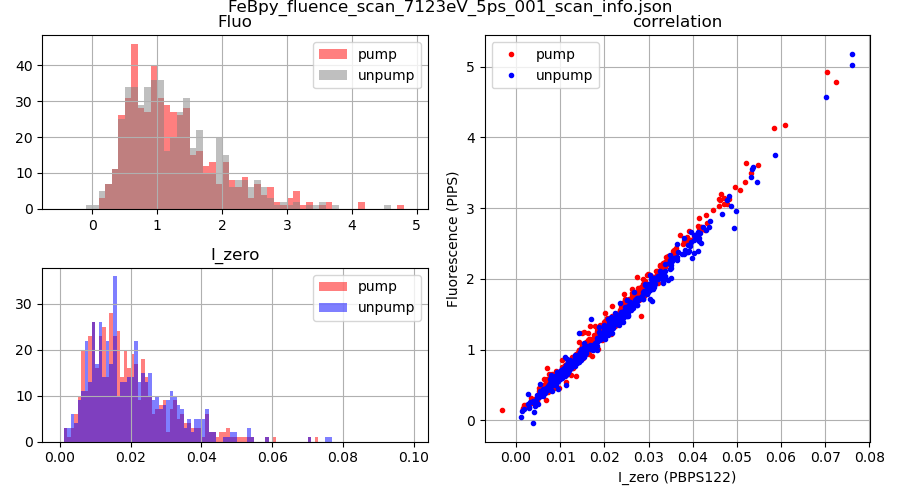

In [44]:
filenumber = 1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122L]
channel_list_all = channel_list_pp + [channel_waveplate]

########################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Waveplate_deg = scan.readbacks
step = scan[filenumber]
print (step)

resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

IzeroFEL_pump_shot = resultsPP[channel_Izero122L].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122L].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

#(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
# DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(fn, channel_energy)

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

print ("Waveplate = {} degrees".format(Waveplate_deg[filenumber]))
print ("Median value Izero (all) = {}".format(np.median(np.concatenate((IzeroFEL_pump_raw, IzeroFEL_unpump_raw), axis=0))))
print ("Median value fluo (all) = {}".format(np.median(np.concatenate((DataFluo_pump_shot_raw, DataFluo_unpump_shot_raw), axis=0))))
print ("Correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))

fig = plt.figure(figsize=(9,5))
plt.suptitle(fc.selected.split('/')[-1], y =1)
plt.subplots_adjust(top=0.9)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,5,0.1), facecolor='red', label="pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.5,5,0.1), facecolor='grey', label="unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.1,0.001), facecolor='red', label='pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.1,0.001), facecolor='blue', label ='unpump', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

#plt.tight_layout()

plt.show()

In [31]:
filenumber = 1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122L]
channel_list_all = channel_list_pp + [channel_waveplate]

min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Waveplate_deg = scan.readbacks
step = scan[filenumber]
print (step)

resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

IzeroFEL_pump_shot = resultsPP[channel_Izero122L].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122L].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Waveplate angle = {} deg".format(Waveplate_deg[filenumber]))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))


Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:37 07.07.2019
    mtime difference: -0:11:19.007286
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF06T04V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF06T04V01.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:45 07.07.2019
    mtime difference: -0:19:33.451366
SFDataFiles("/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.BSREAD.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF02T09V02.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF06T04V01.h5"): 62 channels

----------

<IPython.core.display.Javascript object>


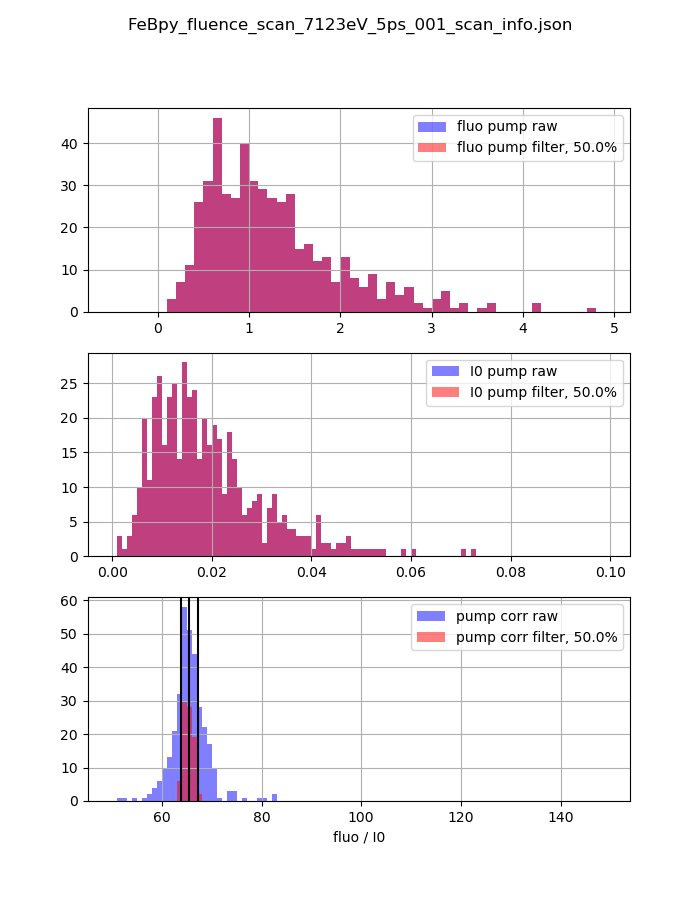

quantile range = 0.25 0.75


In [49]:
plt.figure(figsize = (7,9))
plt.suptitle(fc.selected.split('/')[-1])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,5,0.1), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,5,0.1), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.1,0.001), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.1,0.001), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(50,150,1)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

#plt.tight_layout()

plt.show()
print ('quantile range = {}'.format(0.5 - quantile_corr/2), 0.5 + quantile_corr/2)